# 🎨 GAN Tutorial: Generate Cartoon Faces using PyTorch

## 📌 Objectives
- Understand the structure of a basic GAN.
- Implement a simple DCGAN in PyTorch.
- Train it on a visually interesting dataset: **Cartoon Faces (Anime Faces)**
- Generate and visualize fake images after training.

## 🧠 What is a GAN?
A Generative Adversarial Network (GAN) is composed of two neural networks:
- **Generator (G):** learns to generate new data similar to the training data.
- **Discriminator (D):** learns to distinguish real data from generated (fake) data.

These two networks play a **minimax game** where the generator tries to fool the discriminator.

![GAN Flow](https://raw.githubusercontent.com/rajathkmp/GAN-AnimeFace/master/imgs/gan_structure.png)

## 📦 Dataset
We'll use a preprocessed version of the **Anime Faces Dataset** with 64x64 RGB images.

Dataset Source: [https://www.kaggle.com/splcher/animefacedataset](https://www.kaggle.com/splcher/animefacedataset)


Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 99% 389M/395M [00:01<00:00, 386MB/s]
100% 395M/395M [00:01<00:00, 380MB/s]


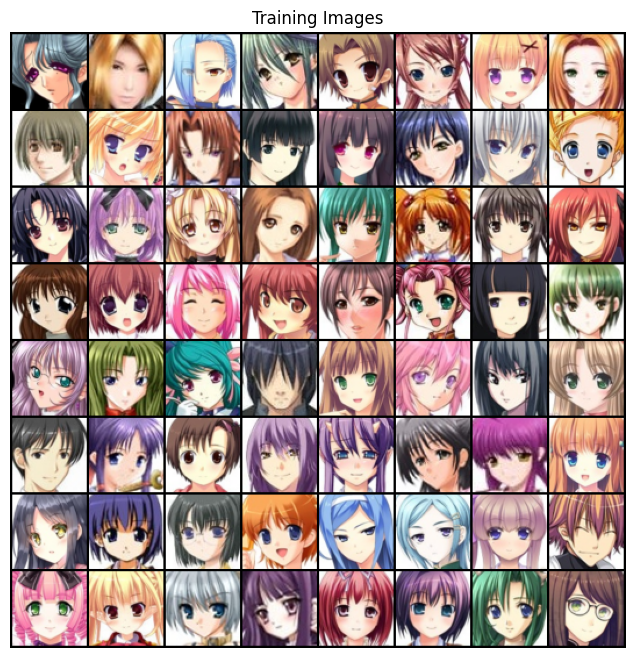

In [1]:
# 📦 Install Required Libraries
!pip install -q kaggle
import os
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'  # Replace with your Kaggle username
os.environ['KAGGLE_KEY'] = 'your_kaggle_api_key'        # Replace with your Kaggle API Key

# Download dataset
!kaggle datasets download -d splcher/animefacedataset
!unzip -q animefacedataset.zip -d data

# 🧼 Imports and Configs
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
image_size = 64
batch_size = 128
nz = 100          # Size of latent vector
ngf = 64          # Generator feature maps
ndf = 64          # Discriminator feature maps
num_epochs = 20   # Keep it low for Colab
lr = 0.0002
beta1 = 0.5

# 🎨 Data Loader
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = dset.ImageFolder(root='data', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 🔍 Visualize Dataset
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [2]:
# 🎨 Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

# 🔍 Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),       # 64 → 32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 32 → 16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # 16 → 8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), # 8 → 4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # 4 → 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)  # Returns [batch_size]


# Initialize
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss and Optimizer
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
from torchvision.utils import save_image
import os

# 🏷️ Labels
real_label = 1.
fake_label = 0.

# 📊 Logs
img_list = []
G_losses = []
D_losses = []

# 📁 Create folder for saved images
os.makedirs("generated_images", exist_ok=True)

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ## -------- Update Discriminator -------- ##
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ## -------- Update Generator -------- ##
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants D to think fakes are real
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 📈 Logging losses
        if i % 50 == 0:
            print(f'[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')
            G_losses.append(errG.item())
            D_losses.append(errD.item())

    ## -------- Save Sample Images Per Epoch -------- ##
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()

    # Save to list for later animation
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # Save to disk
    save_image(fake, f"generated_images/epoch_{epoch+1:02d}.png", normalize=True)

print("Training complete. Images saved in 'generated_images/'")


Starting Training Loop...
[1/20][0/497] Loss_D: 0.1587 Loss_G: 6.9465
[1/20][50/497] Loss_D: 0.0996 Loss_G: 7.7917
[1/20][100/497] Loss_D: 1.6447 Loss_G: 7.2232
[1/20][150/497] Loss_D: 0.0688 Loss_G: 5.7191
[1/20][200/497] Loss_D: 0.0934 Loss_G: 5.4739
[1/20][250/497] Loss_D: 0.1317 Loss_G: 10.1241
[1/20][300/497] Loss_D: 0.1498 Loss_G: 7.2660
[1/20][350/497] Loss_D: 0.3470 Loss_G: 20.1559
[1/20][400/497] Loss_D: 0.0192 Loss_G: 7.7918
[1/20][450/497] Loss_D: 0.4221 Loss_G: 15.7060
[2/20][0/497] Loss_D: 0.1130 Loss_G: 8.6772
[2/20][50/497] Loss_D: 0.2227 Loss_G: 6.8128
[2/20][100/497] Loss_D: 0.0293 Loss_G: 6.1368
[2/20][150/497] Loss_D: 0.1005 Loss_G: 6.9563
[2/20][200/497] Loss_D: 0.1499 Loss_G: 9.9848
[2/20][250/497] Loss_D: 0.0103 Loss_G: 5.9243
[2/20][300/497] Loss_D: 0.0498 Loss_G: 7.7968
[2/20][350/497] Loss_D: 0.0346 Loss_G: 5.7119
[2/20][400/497] Loss_D: 0.0647 Loss_G: 4.9859
[2/20][450/497] Loss_D: 0.0707 Loss_G: 5.6445
[3/20][0/497] Loss_D: 0.1479 Loss_G: 7.3945
[3/20][50/497

In [ ]:
# 📷 Animation of progress
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())


In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# 🔮 Generate random noise
noise = torch.randn(64, nz, 1, 1, device=device)

# 🧙‍♂️ Generate fake images using trained Generator
netG.eval()  # Set G to eval mode
with torch.no_grad():
    fake_images = netG(noise).detach().cpu()

# 🖼️ Display the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Cartoon Faces")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()
